# Homework 2: Emergent communication models

This homework assignment is to be completed in groups. It is due on December 18, 2025 (midnight). Please upload *all files you created or modified* to the homework folder of your group in studIP.

Group number:

Names:

*General note: It is permitted to use AI tools for coding. Please refer to the uploaded manual `AI_Tools_Guidelines` for recommended ways how to use AI to advance your studies in a way that supports your learning. That means that you should not be satisfied if an AI tool hands you a working version of your code, but that you should put in effort to understand how exactly the problem is solved. Another note of caution: What might work for large programming languages like Python, does not necessarily work for Stan. Check your code carefully and do NOT blindly trust AI.*

## Introduction
In the past weeks, you learned about classical neural network approaches to modeling language, about Reinforcement learning and how these two can be combined with the aim of modeling communication in the emergent communication modeling framework.
The goal of this homework assignment is to learn to apply these models. You will be working with a Github repository of my own research. Learning how to work with this repository will qualify you for conducting your study project or thesis within this project.
Below, you receive a sample project and are guided through the steps of conducting it. For all steps, it is expected that you comment your code, explain what you are doing and why, and interpret all your outcomes and results. 

## 1) Creating the environment and installing packages (non-graded)
This is a prerequisite for the following tasks and is therefore non-graded. Please let me know if you run into problems with installing everything. Follow the installation guide in the [emergent-abstractions repository](https://github.com/kristinakobrock/emergent-abstractions/tree/main) and validate that you can run the training (with a small number of epochs and dataset). Follow the tutorial in the [Tutorial Github repository](https://github.com/kristinakobrock/tutorial-emergent-abstractions/tree/main) to make yourself familiar with the code.

For the following tasks, you can either work directly with the main repository (recommended) or work with the tutorial code.

## 2) Dataset (18 points)
The goal is to implement a hierarchical dataset that follows the following logic from the paper by Hawkins et al., 2018: [Emerging abstractions](https://escholarship.org/uc/item/81s4d7fv)
<img src="./img/hierarchy.png" width="400"/>
It differs from the default dataset because the default dataset includes all combinations of objects without implementing a hierarchy. Consider the following example for the default dataset with 3 attributes and 3 values. Concepts are implemented as tuples of objects and fixed vectors which indicate which attributes are relevant to the concept, e.g. ([[2,1,1],[1,0,1],[1,2,1]],(0,0,1)). Where the fixed vector (0,0,1) indicates that only the third attribute is relevant to the concept. [2,1,1],[1,0,1],[1,2,1] are possible objects that satisfy this constraint. You can think of the objects as being a small red circle, a large blue circle and a large green circle - all belonging to the concept 'circle'. Now, in the default dataset, all combinations of attributes are possible, i.e. the higher-level concept don't need to be circles, but could also be the color dimension or the size dimension by specifying the fixed vector as (1,0,0) or (0,1,0). While this certainly makes a lot of sense for compositional features as the ones used here, natural concepts are structured in taxonomic hierarchies (e.g., dalmatian, dog, animal). The goal here is to implement a hierarchical dataset.

### 2.1) Adapting the dataset (12 points)
Adapt the function `get_fixed_vectors` in `dataset.py` to account for hierarchically structured concepts.
Your solution should work for varying dataset sizes and be neatly integrated with the currently available code. Specify a folder where the results for this experiment should be saved to.

### 2.2) Creating the datasets (6 points)
Use the script `pickle_ds.py` to construct 3 datasets with the following attribute-value combinations D(attributes, values):
- D(3,4)
- D(4,4)
- D(3,8)

In [ ]:
# Need to be run only once, datasets are saved locally

# D(3,4) --> three attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 
# D(4,4) --> four attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 4
# D(3,8) --> eight attributes with eight values each
!python pickle_ds.py --dimensions 8 8 8

# hierarchical flag triggers hierarchical generation of fixed vectors & changes the saving path for the dataset
# D(3,4) --> three attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 --hierarchical
# D(4,4) --> four attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 4 --hierarchical
# D(3,8) --> eight attributes with eight values each
!python pickle_ds.py --dimensions 8 8 8 --hierarchical



Creating train_ds and val_ds...
100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 54.66it/s]

Creating test_ds...
100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 53.80it/s]
Data set is saved as: data/standard/dim(3,4)_sf10.ds
Creating train_ds and val_ds...
100%|█████████████████████████████████████████| 499/499 [00:19<00:00, 25.70it/s]

Creating test_ds...
100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 28.24it/s]
Data set is saved as: data/standard/dim(4,4)_sf10.ds
Creating train_ds and val_ds...
100%|█████████████████████████████████████████| 582/582 [00:17<00:00, 33.05it/s]

Creating test_ds...
100%|█████████████████████████████████████████| 146/146 [00:04<00:00, 34.12it/s]
Data set is saved as: data/standard/dim(3,8)_sf10.ds
Creating train_ds and val_ds...
100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 54.91it/s]

Creating test_ds...
100%|███████████████████████████████████████████| 25/25 [00:00

## 3) Model simulations (12 points)
Think about which conditions (i.e., settings) you need to compare to discuss whether the implementation of the hierarchical dataset has any measurable impact on the emerging language. Specify which conditions you will compare and why and state your hypotheses. Simulate five runs for each of the datasets and each of the conditions. For hyperparameters, it is recommended to either stick to hyperparameters that were used before (check publications or default settings) or do a grid search over hyperparameters if you expect different hyperparameters to work better.

#### Explanation on conditions

We have two main directions to consider in the setting of out conditions. The one is the difference between standard (flat) and hierarchical data. Additionally we will compare the different dataset settings in terms of number of attributes and number of values. So we have a between group comparison of the flat vs. hierarchical conditions per dataset configuration, but also a within group comparison between the dataset settings D(3,4),D(3,8), and D(4,4) with D(n attributes, m values per attribute).

We hypothesize that the agents trained on the hierarchical data will perform better than the agents trained on the flat data as the hierarchical structure provides an inductive bias and scaffolding for the agents to converge on a compositional communication scheme.

In settings with higher numbers of attributes we predict that the higher dimensionality will yield slower learning and increased difficulty in solving the task. This might, for instance, be represented via a tendency towards longer messages as more information needs to be conveyed for coordination. However, we assume this to be somewhat mitigated in the hierarchical condition for the above stated reason. Similarly, in settings with higher numbers of values we predict that performances will be drop to some extent as the number of possible objects rises which will yield more pressure towards compostionality.

We can verify the impact of the dimension of the interactions have on the results where the number of fixed atributes change with the size of the game (we will discuss this in more depth in the point [5] Discussion). It is also worth mentioning that it can impact the results of the simulation the game size and scaling factor but we did not account for that options in the databases so it is out of the scope of this experiment.

### Loading necessary modules

In [1]:
# import Python packages
from argparse import Namespace
import torch
# print(torch.__version__)
# import torch.utils.data
import torch.nn as nn
import egg.core as core
import os
import pickle
import itertools
import yaml

# import modules from files
import dataset as dataset
from archs import Sender, Receiver
from language_analysis_local import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

def load_config(path: str) -> Namespace:
    """Read a yaml file and return an argparse.Namespace."""
    with open(path, 'r') as f:
        cfg_dict = yaml.safe_load(f)          # → plain dict
    return Namespace(**cfg_dict) 

# dataset split
SPLIT = (0.6, 0.2, 0.2)

### Main functionalities

We put the main functionalities detailed in the tutorial into different function for easier and more flexible training later. Most content is equal to the tutorial contents. If changed, we added a comment stating so.


In [2]:
def set_vocab_size_msg_len(opts):
    # vocab size and message length
    opts.dimensions = list(itertools.repeat(opts.values, opts.attributes))
    vocab_size = opts.vocab_size_user

    # allow user to specify a maximum message length
    if opts.max_mess_len > 0:
        max_len = opts.max_mess_len
    # default: number of attributes
    else:
        max_len =  max(len(opts.dimensions), 5)
    
    return vocab_size, max_len


In [3]:
# CHANGED
# adjusted the folder structure in such a way that results are sorted to standard (flat) and hierarchical conditions
def setup_folder_structure(opts, hierarchical=False):
    # set up folders for saving
    if not os.path.exists('data'):
            os.makedirs('data')
    if not os.path.exists('results'):
        os.makedirs('results')
        
    data_set_name = '(' + str(len(opts.dimensions)) + ',' + str(opts.dimensions[0]) + ')'
    folder_name = (data_set_name + '_game_size_' + str(opts.game_size))

    # define game setting from args
    if opts.context_unaware:
        opts.game_setting = 'context_unaware'
    else:
        opts.game_setting = 'context_aware'

    if hierarchical:
        hierarchical_path = 'hierarchical'
    else:
        hierarchical_path = 'standard'

    path_name = os.path.join(opts.path, 'results', hierarchical_path, folder_name)

    # create subfolders if necessary
    opts.game_path = os.path.join(path_name, opts.game_setting)
    if not os.path.exists(opts.game_path):
        os.makedirs(opts.game_path)

    # saving
    if opts.save:
        # make folder for new run
        latest_run = len(os.listdir(opts.game_path))
        opts.save_path = os.path.join(opts.game_path, str(latest_run))
        if not os.path.exists(opts.save_path):
            os.makedirs(opts.save_path)
        pickle.dump(opts, open(opts.save_path + '/params.pkl', 'wb'))
        save_epoch = opts.n_epochs
    else:
        save_epoch = None



In [4]:
def load_dataset(opts):

    if opts.load_dataset == '':
        data_set = dataset.DataSet(opts.dimensions,
                                game_size=opts.game_size,
                                scaling_factor=opts.scaling_factor,
                                device=device)
    else:
        # load the dataset specified in the opts
        data_set = torch.load(opts.path + 'data/' + opts.load_dataset, weights_only=False)
        print('data loaded from: ' + 'data/' + opts.load_dataset)
        
    train, val, test = data_set

    dimensions = train.dimensions

    train = torch.utils.data.DataLoader(train, batch_size=opts.batch_size, shuffle=True)
    val = torch.utils.data.DataLoader(val, batch_size=opts.batch_size, shuffle=False, drop_last=True)
    test = torch.utils.data.DataLoader(test, batch_size=opts.batch_size, shuffle=False)

    return dimensions, train, val, test

In [5]:
def loss(_sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    Loss needs to be defined for gumbel softmax relaxation.
    For a discriminative game, accuracy is computed by comparing the index with highest score in Receiver
    output (a distribution of unnormalized probabilities over target positions) and the corresponding 
    label read from input, indicating the ground-truth position of the target.
    Adaptation to concept game with multiple targets after Mu & Goodman (2021) with BCEWithLogitsLoss
        receiver_output: Tensor of shape [batch_size, n_objects]
        labels: Tensor of shape [batch_size, n_objects]
    """
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(receiver_output, labels)
    receiver_pred = (receiver_output > 0).float()
    per_game_acc = (receiver_pred == labels).float().mean(1).cpu().numpy()  # all labels have to be predicted correctly
    acc = per_game_acc.mean()
    return loss, {'acc': acc}

In [6]:
def game_setup(dimensions, vocab_size, max_len, opts):
    # Game
    # initialize sender and receiver agents
    sender = Sender(opts.hidden_size, sum(dimensions), opts.game_size, opts.context_unaware)
    receiver = Receiver(sum(dimensions), opts.hidden_size)

    # initialize game
    sender = core.RnnSenderGS(sender,
                            vocab_size,
                            int(opts.hidden_size / 2),
                            opts.hidden_size,
                            cell=opts.sender_cell,
                            max_len=max_len,
                            temperature=opts.temperature)

    receiver = core.RnnReceiverGS(receiver,
                                vocab_size,
                                int(opts.hidden_size / 2),
                                opts.hidden_size,
                                cell=opts.receiver_cell)

    game = core.SenderReceiverRnnGS(sender, receiver, loss, length_cost=opts.length_cost)
    return game, sender

In [7]:
def train_and_callbacks(game, sender, save_epoch, train, val, opts):
    # Training
    # set optimizer
    optimizer = torch.optim.Adam([
        {'params': game.sender.parameters(), 'lr': opts.learning_rate},
        {'params': game.receiver.parameters(), 'lr': opts.learning_rate}
    ])

    # setup training and callbacks
    # results/ data set name/ kind_of_dataset/ run/
    callbacks = [SavingConsoleLogger(print_train_loss=True, as_json=True,
                                    save_path=opts.save_path, save_epoch=save_epoch),
                core.TemperatureUpdater(agent=sender, decay=opts.temp_update, minimum=0.5)]
    if opts.save:
        callbacks.extend([core.callbacks.InteractionSaver([opts.n_epochs],
                                                        test_epochs=[opts.n_epochs],
                                                        checkpoint_dir=opts.save_path),
                        core.callbacks.CheckpointSaver(opts.save_path, checkpoint_freq=0)])

    trainer = core.Trainer(game=game, optimizer=optimizer,
                        train_data=train, validation_data=val, callbacks=callbacks, device=device)

    # if checkpoint path is given, load checkpoint and skip training
    if opts.load_checkpoint:
        trainer.load_from_checkpoint(opts.checkpoint_path, map_location=device)
    else:
        trainer.train(n_epochs=opts.n_epochs)
    
    return trainer


In [8]:
def test_training(trainer, test, opts):
    # after training evaluate performance on the test data set
    if len(test):
        trainer.validation_data = test
        eval_loss, interaction = trainer.eval()
        acc = torch.mean(interaction.aux['acc']).item()
        print("test accuracy: " + str(acc))
        if opts.save:
            loss_and_metrics_path = os.path.join(opts.save_path, 'loss_and_metrics.pkl')
            if os.path.exists(loss_and_metrics_path):
                with open(loss_and_metrics_path, 'rb') as pickle_file:
                    loss_and_metrics = pickle.load(pickle_file)
            else:
                loss_and_metrics = {}

            loss_and_metrics['final_test_loss'] = eval_loss
            loss_and_metrics['final_test_acc'] = acc
            pickle.dump(loss_and_metrics, open(opts.save_path + '/loss_and_metrics.pkl', 'wb'))



### Training

Here is where we put the the function together and run the full training.

In [ ]:
# ist of configurations per condidtion and each dataset setting, to be loaded from files
configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_4_4.yml', 'config_hierarchical_3_8.yml',
           'config_standard_3_4.yml', 'config_standard_4_4.yml', 'config_standard_3_8.yml']

n_runs = 5
for file in configs:
# for each setting we take 5 runs of the full training (same structure as in the tutorial) and save them to respective folders
    for n in range(n_runs):   
        opts = load_config(file)
        vocab_size, max_len = set_vocab_size_msg_len(opts)
        dimensions, train, val, test = load_dataset(opts)
        if "hierarchical" in file:
            folder_name = setup_folder_structure(opts, hierarchical=True)
        else:
            folder_name = setup_folder_structure(opts, hierarchical=False)

        game, sender = game_setup(dimensions, vocab_size, max_len, opts)
    
        trainer = train_and_callbacks(game, sender, save_epoch=opts.n_epochs, train=train, val=val, opts=opts)
        test_training(trainer, test, opts)

    
    

In [9]:
# get save paths separately, to make sure to have the correct paths even when the cell above is not executed again
def get_dataset_paths(results_root="results"):
    results_root = Path(results_root)
    dataset_paths = set()

    for p in results_root.rglob("*"):
        if p.is_dir() and p.name.isdigit():
            dataset_paths.add(p.parent.parent)

    return sorted(dataset_paths)



## 4) Analysis (50 points)
### 4.1) Model performance (10 points)
Assess the model performance for each dataset and condition.
### 4.2) Quantitative analysis (25 points)
Analyze the emerging languages in your conditions with metrics as you see fit. You can check out the emergent-abstractions github repository for inspiration. Your analysis should at least include the following metrics:
- NMI
- message length

Choose two additional metrics or types of quantitative analysis and interpret all your results.

### 4.3) Qualitative analysis (15 points)
Look at the emerging messages and concepts from the interaction files (see tutorial). Assess the differences between simulations with and without the hierarchical datasets. Can you make out specific test cases where the results (should) differ? Come up with a good way to visualize your results, either as a tidy table, or a visual representation, for example with clustering methods.

### Assessing model performance

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
plt.style.use('default')
import random
import seaborn

from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import *

Getting the accuracy scores of all runs, dataset settings, and conditions.

In [ ]:
dataset_paths = get_dataset_paths("results")

# adjusted tutorial code to fit the number of runs and datasets
all_accuracies = load_accuracies(dataset_paths, n_runs=5, n_epochs=10, val_steps=1,context_unaware=False)

titles = ("D(3,4)- hierarchical", "D(3,8)- hierarchical", "D(4,4)- hierarchical",
          "D(3,4)- standard", "D(3,8)- standard", "D(4,4)- standard")

# taking the mean of all runs
train_mean = np.mean(all_accuracies["train_acc"], axis=1)[:, np.newaxis, :]  # shape (num_datasets, 1, num_epochs)
val_mean   = np.mean(all_accuracies["val_acc"], axis=1)[:, np.newaxis, :]    # shape (num_datasets, 1, num_epochs)




Visualising (average) accuracy scores

Condition                 | Initial Train Accuracy
------------------------------------------------
D(3,4) hierarchical       |             0.5513
D(3,8) hierarchical       |             0.7047
D(4,4) hierarchical       |             0.7192
D(3,4) standard           |             0.5518
D(3,8) standard           |             0.7103
D(4,4) standard           |             0.7251
Condition                 | Initial Val Accuracy
------------------------------------------------
D(3,4) hierarchical       |             0.6812
D(3,8) hierarchical       |             0.7904
D(4,4) hierarchical       |             0.7634
D(3,4) standard           |             0.6839
D(3,8) standard           |             0.7675
D(4,4) standard           |             0.7680
Condition                 | Final Train Accuracy
------------------------------------------------
D(3,4) hierarchical       |             0.9108
D(3,8) hierarchical       |             0.9304
D(4,4) hierarchical       |             0.9371

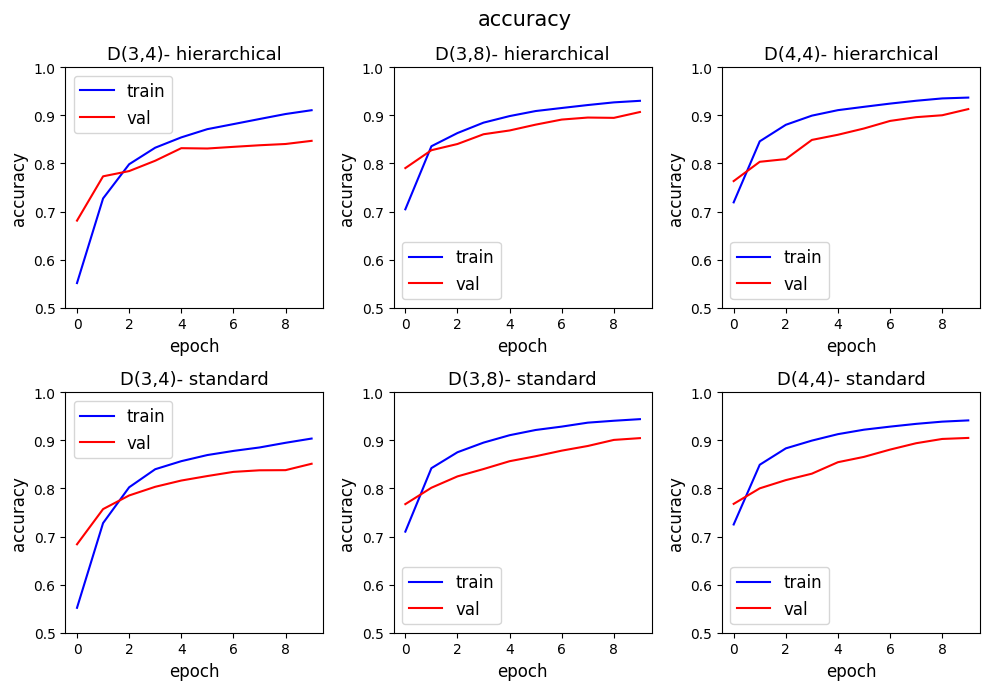

In [32]:

# Initial accuracies
initial_train_acc = {
    "D(3,4) hierarchical": train_mean[0][0][0],
    "D(3,8) hierarchical": train_mean[1][0][0],
    "D(4,4) hierarchical": train_mean[2][0][0],
    "D(3,4) standard": train_mean[3][0][0],
    "D(3,8) standard": train_mean[4][0][0],
    "D(4,4) standard": train_mean[5][0][0],
}

initial_val_acc = {
    "D(3,4) hierarchical": val_mean[0][0][0],
    "D(3,8) hierarchical": val_mean[1][0][0],
    "D(4,4) hierarchical": val_mean[2][0][0],
    "D(3,4) standard": val_mean[3][0][0],
    "D(3,8) standard": val_mean[4][0][0],
    "D(4,4) standard": val_mean[5][0][0],
}

# Printing initial accuracies
print(f"{'Condition':<25} | {'Initial Train Accuracy':>18}")
print("-" * 48)

for k, v in initial_train_acc.items():
    print(f"{k:<25} | {v:>18.4f}")

print(f"{'Condition':<25} | {'Initial Val Accuracy':>18}")
print("-" * 48)

for k, v in initial_val_acc.items():
    print(f"{k:<25} | {v:>18.4f}")

# Final accuracies
final_train_acc = {
    "D(3,4) hierarchical": train_mean[0][0][-1],
    "D(3,8) hierarchical": train_mean[1][0][-1],
    "D(4,4) hierarchical": train_mean[2][0][-1],
    "D(3,4) standard": train_mean[3][0][-1],
    "D(3,8) standard": train_mean[4][0][-1],
    "D(4,4) standard": train_mean[5][0][-1],
}

final_val_acc = {
    "D(3,4) hierarchical": val_mean[0][0][-1],
    "D(3,8) hierarchical": val_mean[1][0][-1],
    "D(4,4) hierarchical": val_mean[2][0][-1],
    "D(3,4) standard": val_mean[3][0][-1],
    "D(3,8) standard": val_mean[4][0][-1],
    "D(4,4) standard": val_mean[5][0][-1],
}

# Printing final accuracies
print(f"{'Condition':<25} | {'Final Train Accuracy':>18}")
print("-" * 48)

for k, v in final_train_acc.items():
    print(f"{k:<25} | {v:>18.4f}")

print(f"{'Condition':<25} | {'Final Val Accuracy':>18}")
print("-" * 48)

for k, v in final_val_acc.items():
    print(f"{k:<25} | {v:>18.4f}")


# plotting accuracy per dataset setting and condition 
plot_training_trajectory(
    train_mean,
    val_mean,
    ylim=(0.5, 1),
    steps=(1, 1),
    n_epochs=10,
    plot_shape=(2,3),
    plot_indices=(1, 2, 3, 4, 5, 6),
    titles=titles,
)




## Answer 4.1

The figure above shows the  mean training and validation accuracy of each setting with training configured with the default parameters specified in each dataset's configuration file over a total of five runs. All values of final mean train and mean validation accuracies, as well their respective initial mean accuracies are displayed in the tables from the cell output above.   
The model performance between all dataset settings (different combinations of  number of attributes and values) and the two conditions (standard and hierarchical) are rather similar at a glance. The performance of all dataset settings in the hierarchical condition is slightly better than their counterparts in the standard condition.   
All settings reach a final training accuracy score between 90 and 94% and a validation accuracy score somewhere between 84 and 92%.  The best final training accuracy yields the D(3,8) standard setting (~94%) and the best final validation accuracy score yields the D(4,4) hierarchical setting (~91%).   
Rather than between the conditions there are bigger differences observable within the conditions between the dataset settings. The setting with only three attributes and four values per attribute (D(3,4)) start out with the lowest accuracies (both ~55% train acc, ~68% val acc) among all settings and learn the slowest. The final validation accuracy is also the lowest for both conditions with this setting values ~85% each. Between the two conditions there does not seem to be a significant difference.   
In the dataset setting with three attributes and eight values per attribute( D(3,8)), we have very similar performances between the conditions again with the most notable difference being that the standard condition has a bigger performance gap between the train and validation accuracies. The gap seems to arise from the hierarchical condition model having a better initial validation performance  after the first epoch, with similar shapes of learning curves across the epochs. The initial validation performance (~79%) in the hierarchical condition is slightly higher than in the standard condition (~77%), but the shapes of the learning curves are similar in effect, but the hierarchical one is shifted upwards.
The learning curves of the four attribute, four values (D(4,4)) setting are similar to the performance of the D(3,8) setting. Both conditions yield final train accuracies of ~94% and final validation accuracies ~91%.   


### Quantitative Analysis

In [14]:
# # plotting the message length per dataset setting and condition
# plot_training_trajectory(
#     all_accuracies['train_acc'], 
#     all_accuracies['val_acc'], 
#     message_length_train=all_accuracies['train_message_lengths'], 
#     message_length_val=all_accuracies['val_message_lengths'], 
#     steps=(1, 1),
#     n_epochs=10, 
#     plot_indices=(1, 2, 3, 4, 5, 6),
#     titles=titles,
#     message_length_plot=True, 
#     train_only=True
#     )

#### Accessing the entropy data

In [15]:
# n_runs = 5
# dataset_paths = [str(p) for p in get_dataset_paths("results")]

# print(dataset_paths)

# for idx, path in enumerate(dataset_paths):
#     configs =['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
#            'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']

#     for n in range(n_runs):
#         opts = load_config(configs[idx])
#         path_to_interaction = (path + '/context_aware/' + str(n) + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')

#         interaction = torch.load(path_to_interaction, weights_only=False)

#         scores = information_scores(interaction, opts.attributes, opts.values, normalizer="arithmetic", is_gumbel=True, trim_eos=True, max_mess_len=21)   

#         pickle.dump(scores, open(path + '/context_aware/' + str(n) + '/entropy_scores.pkl', 'wb'))

In [16]:
# dataset_paths = [str(p) for p in get_dataset_paths("results")]
# # all_entropies  = load_entropies(dataset_paths, n_runs=5,context_unaware=False)

In [17]:
# # this is implemented in `analysis.ipynb`
# entropies = [all_entropies['NMI'], all_entropies['effectiveness'], all_entropies['consistency']]
# entropy_dict = {}
# for i, score in enumerate(list(all_entropies.keys())[:3]):
#     results = entropies[i]
#     mean = np.nanmean(results, axis=-1)
#     sd = np.std(results, axis=-1)
#     for idx, d in enumerate(["D(3,4) - hierarchical: ", "D(3,8) - hierarchical: ", "D(4,4) - hierarchical: ",
#           "D(3,4) - standard: ", "D(3,8) - standard: ", "D(4,4) - standard: "]):
#         entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
# entropy_dict

In [18]:
# n_runs = 5
# for idx, path in enumerate(dataset_paths):
#     configs =['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
#            'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']

#     for n in range(n_runs):
#         opts = load_config(configs[idx])
#         path_to_interaction = (path + '/context_aware/' + str(n) + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')

#         interaction = torch.load(path_to_interaction, weights_only=False)

#         scores = information_scores(interaction, opts.attributes, opts.values, normalizer="arithmetic", is_gumbel=True, trim_eos=True, max_mess_len=21)   

#         pickle.dump(scores, open(path + '/context_aware/' + str(n) + '/entropy_scores.pkl', 'wb'))


#         ml, ml_concept = message_length_per_hierarchy_level(interaction, opts.attributes)

#         pickle.dump(ml, open(path + '/context_aware/' + str(n) + '/message_length.pkl', 'wb'))
#         pickle.dump(ml_concept, open(path + '/context_aware/' + str(n) + '/message_length_hierarchical.pkl', 'wb'))




In [19]:
# ml_dict = {'dataset': [], 'run': [], 'message length': []}

# n_runs = 5
# for idx, path in enumerate(dataset_paths):
#     configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
#            'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']
    
#     datasets = ["D(3,4) - hierarchical", "D(3,8) - hierarchical", "D(4,4) - hierarchical",
#           "D(3,4) - standard", "D(3,8) - standard", "D(4,4) - standard"]
   
#     for n in range(n_runs):
#         opts = load_config(configs[idx])
#         path_to_ml_data = (path + '/context_aware/' + str(n))
#         dataset_name = datasets[idx]

#         ml = pickle.load(open(path_to_ml_data + '/message_length.pkl', 'rb'))
    
#         ml_dict['run'].append(n)
#         ml_dict['dataset'].append(dataset_name)
#         try: 
#             ml_dict['message length'].append(np.mean(ml.numpy()))
#         except: 
#             ml_dict['message length'].append(np.NaN)

# df_ml = pd.DataFrame(ml_dict)



# ml_dict = {'level': [], 'dataset': [], 'run': [], 'message length': []}

# n_runs = 5
# for idx, path in enumerate(dataset_paths):
#     configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_4_4.yml', 'config_hierarchical_3_8.yml',
#            'config_standard_3_4.yml', 'config_standard_4_4.yml', 'config_standard_3_8.yml']
    
#     datasets = ["D(3,4) - hierarchical", "D(3,8) - hierarchical", "D(4,4) - hierarchical",
#           "D(3,4) - standard", "D(3,8) - standard", "D(4,4) - standard"]
   
#     for n in range(n_runs):
#         opts = load_config(configs[idx])
#         path_to_ml_data = (path + '/context_aware/' + str(n))
#         dataset_name = datasets[idx]

#         ml_hierarchical = pickle.load(open(path_to_ml_data + 
#                                            '/message_length_hierarchical.pkl', 'rb'))
        
#         print(ml_hierarchical)
        
#         # if evaluated with the callback throughout training, you get an array for each epoch
#         if isinstance(ml_hierarchical, dict): 
#             ml_hierarchical = ml_hierarchical['message_length_train'][opts.n_epochs]
#             print("is instance")
            
#         for level in range(10):
            
#             ml_dict['level'].append(level)
#             ml_dict['run'].append(n)
#             ml_dict['dataset'].append(dataset_name)
#             try: 
#                 ml_dict['message length'].append(ml_hierarchical[level])
#             except: 
#                 ml_dict['message length'].append(np.NaN)

# df_ml_hierarchical = pd.DataFrame(ml_dict)
# dropped = df_ml_hierarchical.dropna()


In [20]:
# # Create a FacetGrid
# g = seaborn.FacetGrid(pd.DataFrame(df_ml_hierarchical), col="dataset", col_wrap=3, sharey=True, height=4)
# # Map the boxplot to each subplot in the grid
# g.map(seaborn.boxplot, "level", "message length", order=range(4), showmeans=True, meanline=True, meanprops=dict(color="red", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
# g.set_titles(col_template="{col_name}", fontsize=50)
# g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
# for ax in g.axes.flatten():
#     ax.set_title(ax.get_title(), fontsize=17, y=1.05)
#     ax.set_xlabel(ax.get_xlabel(), fontsize=16)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=16)
#     ax.tick_params(axis='x', labelsize=15)
#     ax.tick_params(axis='y', labelsize=15)
#     ax.set_ylim(0,6)
#     ax.yaxis.set_ticks([0,1,2,3,4,5,6])
# g.tight_layout()
# plt.show()

### Qualitative Analysis

In [30]:
import pandas as pd

concepts_df = {'dataset': [], 'run': [], 'interaction': [], 'concept_idx': [],
               'n_objects': [], 'n_fixed_attrs': []}
dataset_paths = [str(p) for p in get_dataset_paths("results")]

n_runs = 5
for idx, path in enumerate(dataset_paths):
    configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
               'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']
    
    dataset_name =path.split("/")[-2] + path.split('/')[-1] 

    for n in range(n_runs):
        opts = load_config(configs[idx])
        path_to_interaction = (path + '/context_aware/' + str(n) +
                               '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')

        interaction = torch.load(path_to_interaction, weights_only=False)

        # loop over all games in this interaction
        sender_input = interaction.sender_input  # shape: (n_games, n_objects * attributes)
        n_targets = sender_input.shape[1] // 2
        target_objects = sender_input[:, :n_targets]
        target_objects = k_hot_to_attributes(target_objects, dimsize=opts.values)

        objects_list, fixed_list = retrieve_concepts_sampling(target_objects, all_targets=True)
        concepts = list(zip(objects_list, fixed_list))

        # save each concept in the DataFrame
        for c_idx, (objects, fixed) in enumerate(concepts):
            concepts_df['dataset'].append(dataset_name)
            concepts_df['run'].append(n)
            concepts_df['interaction'].append(0)  # one interaction object contains all games
            concepts_df['concept_idx'].append(c_idx)
            concepts_df['n_objects'].append(len(objects))
            concepts_df['n_fixed_attrs'].append(int(sum(fixed)))

# Convert to DataFrame
concepts_df = pd.DataFrame(concepts_df)
concepts_df['type'] = concepts_df['dataset'].apply(lambda x: 'hierarchical' if 'hierarchical' in x else 'standard')

# Summary: average abstraction per dataset
summary = concepts_df.groupby('dataset')['n_fixed_attrs'].mean().reset_index()
print(summary)


                          dataset  n_fixed_attrs
0  hierarchical(3,4)_game_size_10       2.599776
1  hierarchical(3,8)_game_size_10       2.778644
2  hierarchical(4,4)_game_size_10       3.385164
3      standard(3,4)_game_size_10       2.612618
4      standard(3,8)_game_size_10       2.768402
5      standard(4,4)_game_size_10       3.372436


/tmp/ipykernel_29638/3433507264.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


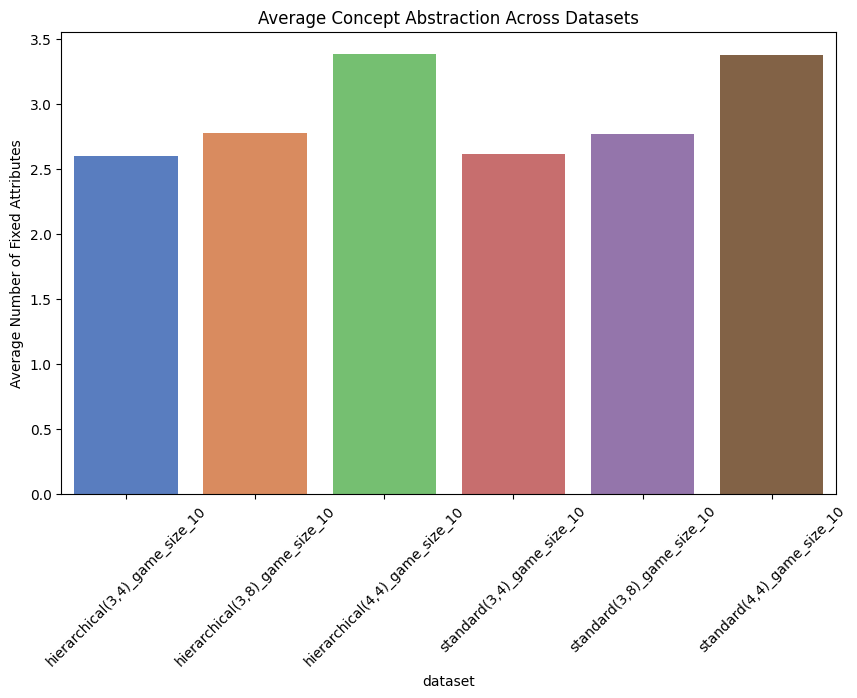

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

abstraction_avg = concepts_df.groupby('dataset')['n_fixed_attrs'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(
    data=abstraction_avg,
    x='dataset',
    y='n_fixed_attrs',
    hue=None,      
    palette='muted'
)
plt.xticks(rotation=45)
plt.ylabel("Average Number of Fixed Attributes")
plt.title("Average Concept Abstraction Across Datasets")
plt.show()


In [31]:
# Concepts per dataset
summary = (
    concepts_df
    .groupby('dataset')
    .agg(
        Dataset_Type=('type', 'first'),                    # hierarchical vs standard
        Avg_Fixed_Attrs=('n_fixed_attrs', 'mean'),         # average abstraction
        Std_Fixed_Attrs=('n_fixed_attrs', 'std'),          # spread of abstraction
        Avg_Concept_Size=('n_objects', 'mean'),            # average size of concepts
        Std_Concept_Size=('n_objects', 'std'),             # spread of concept size
        Total_Concepts=('concept_idx', 'count')            # total number of concepts
    )
    .reset_index()
)

# Round numeric
summary[['Avg_Fixed_Attrs','Std_Fixed_Attrs','Avg_Concept_Size','Std_Concept_Size']] = \
    summary[['Avg_Fixed_Attrs','Std_Fixed_Attrs','Avg_Concept_Size','Std_Concept_Size']].round(2)

# Sort
summary = summary.sort_values('dataset').reset_index(drop=True)

# Display table
summary

,dataset,Dataset_Type,Avg_Fixed_Attrs,Std_Fixed_Attrs,Avg_Concept_Size,Std_Concept_Size,Total_Concepts
0,"hierarchical(3,4)_game_size_10",hierarchical,2.60,0.57,10.0,0.0,8920
1,"hierarchical(3,8)_game_size_10",hierarchical,2.78,0.45,10.0,0.0,58345
2,"hierarchical(4,4)_game_size_10",hierarchical,3.39,0.70,10.0,0.0,59585
3,"standard(3,4)_game_size_10",standard,2.61,0.57,10.0,0.0,9035
4,"standard(3,8)_game_size_10",standard,2.77,0.45,10.0,0.0,58010
5,"standard(4,4)_game_size_10",standard,3.37,0.71,10.0,0.0,59245


### 4.3 Qualitative Analysis: Emerging Concepts

**Avg_Fixed_Attrs** (average abstraction level) measures how many attributes are fixed in a concept.

- Higher values indicate more detailed and specific concepts  
- Lower values indicate more general and abstract concepts  

The highest Avg_Fixed_Attrs values are observed in the following order:  
**D(4,4) > D(3,4), D(3,8)**.

Hierarchical datasets show slightly higher Avg_Fixed_Attrs than standard datasets with the same number of attributes. However, this difference is small.

Datasets with more values per attribute (3,8) also show slightly higher Avg_Fixed_Attrs, indicating more specific concepts.

**Std_Fixed_Attrs** (variation in abstraction) measures how much abstraction varies across concepts.

Smaller datasets or datasets with fewer values per attribute show higher variability (for example, around 0.57 for D(3,4)).  
Larger or more complex datasets show lower variability (approximately 0.45–0.71).

**Avg_Concept_Size** is 10.0 for all datasets, which reflects the fixed game size of 10 target objects.

**Std_Concept_Size** is 0.0 for all datasets, showing that concept sizes are fully consistent across all conditions.

**Total_Concepts** reflects dataset complexity and the number of distinct concepts learned by the agents.

- Higher Total_Concepts means the agent needed to encode more unique concepts to cover all target-object combinations.

Datasets with more values per attribute (3,8) have many more total concepts.  
Datasets with more attributes (4,4) have more total concepts than datasets with fewer attributes (3,4).  
Hierarchical and standard datasets have roughly the same number of total concepts.




## 5) Discussion (20 points)
Summarize your results and discuss whether the hierarchical dataset implementation resulted in measurable differences in the emerging language.

### Discussion:


Within this homework we investigated whether there is a significant effect on an emergent communication model when learning from a flat vs. hierarchical dataset. Additionally we investigated whether the number of attributes and the number possible values per attribute were altering learning in any significant way.  
In the performance, measured by training and validation accuracies, we saw almost no difference between the standard (flat) and the hierarchical condition. Yet we observed that there were differences between the dataset settings. The datasets we used were the attribute, values variations D(3,4), D(3,8), and D(4,4). We noticed that the model performed worst under the D(3,4) setting, while in the other two settings it performed better and similar to each other. Yet all three converge to a similar accuracy score at the end. Initially, this observation is counter to the intuition that the smaller space would be easier to communicate and distinguish and therefore easier to learn. Additionally, we would expect the spaces with more objects (D(3,4): 64, D(4,4): 256, D(3,8): 512) to be harder to distinguish in and therefore yield worse performance. However, this is not what we observe. Instead the small space setting yielded worse performance. We assume the reason for this to be that the small space setting did not encourage the agents for more complex communication, as we did not restrict message length and had only a medium sized game_size and scaling factor. In the other two settings, however, the agents were faced with more complexity in the hierarchy and plainly more possible objects in the flat and hierarchical conditions. So the agents were incentivised to actually come up with a useful strategy beyond memorisation and go towards compositionality.





Overall, agents learn more specific concepts as dataset complexity increases, either through more attributes or more values per attribute. This shows that concept abstraction is mainly driven by the size of the attribute space.

Hierarchical datasets result in slightly higher abstraction levels than standard datasets, especially when the number of attributes increases. However, these differences are very small, indicating that the hierarchical structure has only a limited effect on the emerging language in the current experimental setup.

The number of learned concepts is primarily determined by the combinatorial complexity of the dataset rather than by the presence of hierarchy. Similarly, message length and abstraction vary little between hierarchical and standard datasets, particularly in smaller games such as (3,4) and (3,8).

In summary, while hierarchy slightly influences how concepts and messages are structured, it does not lead to strong or measurable differences in abstraction or communication efficiency under the tested conditions.



## Bonus task (15 bonus points)
You receive 15 bonus points for trying to replicate the above-mentioned study by [Hawkins et al. (2018)](https://escholarship.org/uc/item/81s4d7fv) with a hierarchical dataset. This can be done in the scope of the assignments above. Suitable parameters for creating datasets with different context granularities are implemented in the main Github repository and can be used for this task. Make sure to present an analysis and discussion linking the simulation results to results from the paper.

## X) Reflection (no points, but mandatory)

Reflect on your group work. What went well? What did not go well?

Please note down the group members' team roles anonymously and reflect on how you filled this role.

**Group Work**:

We are very happy to have completed this homework. Our organization was good, and through shared discussions we were able to finish before the deadline. With our shared work, we were able to somewhat complete this task despite its difficulty and the time constraints.

*Specialist + Actualizer*:

I was unfortunately not able to use a lot of programming knowledge in this task. I managed to write some of the needed code, but I lacked the skill to work with a rich pre-existing codebase.
I showed initiative, scheduled meetings, and used my sense of urgency to make sure that deadlines were met.


*Specialist  + Monitor Evaluator*:

I fulfilled my role as specialist to a similar extent as in the first homework assignment. I familiarized myself with the codebase in my own pace and took the time to understand the needed functionalities. What this approach lacked, however, was a fruitful reconvenience with my other group mates which I rather regret. I feel like we could have achieved a more directed workflow if I had not taken myself out of the equation initially.

I also feel that my monitor evaluator tendencies were also useful this time around in order to streamline the writing process.


